In [3]:
from nilearn.datasets import MNI152_FILE_PATH
import pandas as pd
from nilearn import image, glm, plotting, input_data, datasets

import numpy as np


import nibabel as nib


import time
import os
import statsmodels.api as sm
#from nilearn.datasets import load_mni152_gm_template
import pdb

import matplotlib.pyplot as plt
from scipy.stats import binom_test


/home/vayzenbe/anaconda3/envs/brainiak_new/lib/python3.7/site-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)
/home/vayzenbe/anaconda3/envs/brainiak_new/lib/python3.7/site-packages/nilearn/glm/__init__.py:56: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  'It may change in any future release of Nilearn.', FutureWarning)


In [11]:
study ='docnet'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
out_dir = f'{study_dir}/derivatives/fc'
results_dir = '/user_data/vayzenbe/GitHub_Repos/docnet/results/'
exp = 'catmvpa'

subj_list = [2001,2002,2003,2004, 2005, 2007, 2008, 2012, 2013, 2014, 2015, 2016, 2017, 2018]


ventral_rois = ['LO_toolloc', 'PFS_toolloc']
dorsal_rois = ['PPC_spaceloc',  'PPC_toolloc','PPC_distloc', 'APC_spaceloc',  'APC_toolloc','APC_distloc']
file_suf = '_supp'

brain_mask = image.load_img('/user_data/vayzenbe/GitHub_Repos/fmri/roiParcels/mruczek_parcels/binary/all_visual_areas.nii.gz')
affine = brain_mask.affine
vols = 331

alpha = .05

In [7]:
def dist_normalize(brain_mask, seed_mask, stat):
    
    #create empty brain
    dist_img = np.zeros(stat.shape)
    
    #extract center of seed
    seed_coords = np.mean(np.array(list(np.where(seed_mask == 1))), axis =1)
    seed_coords = seed_coords.reshape((1,3))

    #extract all coords of brain mask
    brain_coords = np.transpose(np.array(list(np.where(brain_mask == 1))))
    brain_df = pd.DataFrame(brain_coords, columns = ['x','y','z'])

    #Calculate dist of all mask coords from seed
    dists = np.linalg.norm(brain_coords-seed_coords, axis=-1)
    dists = dists.reshape((dists.shape[0], 1))
    brain_df['dist'] = dists
    #min/max normalize coords
    brain_df['dist_norm'] = (brain_df['dist'] - brain_df['dist'].min()) / (brain_df['dist'].max() - brain_df['dist'].min())

    #extract stat vals from brain image
    stat_vals = stat[tuple(np.transpose(brain_coords[:,0:3].astype(int)))]
    stat_vals = stat_vals.reshape((stat_vals.shape[0],1))
    brain_df['zstat'] =stat_vals

    #create distance normalized image
    brain_df['zstat_distnorm'] = brain_df['zstat'] * brain_df['dist_norm']

    dist_img[tuple(np.transpose(brain_coords[:,0:3].astype(int)))] = brain_df['zstat_distnorm']

    return dist_img

In [13]:
"""
run 2nd level model on each subjects MVPD analysis
"""

second_level_model = glm.second_level.SecondLevelModel(smoothing_fwhm=None, mask_img = brain_mask)
alpha = .05
rois = ["rPPC_spaceloc", "rAPC_spaceloc", "lPPC_spaceloc", "lAPC_spaceloc"]
#rois = ["rPPC_spaceloc"]
mask_img = image.get_data(brain_mask)

for rr in rois:
    fc_img = []
    for ss in subj_list:
        sub_dir = f'{study_dir}/sub-{study}{ss}/ses-02/'
        roi_dir = f'{sub_dir}/derivatives/rois'
        
        if os.path.exists(f'{roi_dir}/spheres/{rr}_sphere.nii.gz'):
            seed_img = image.get_data(image.load_img(f'{roi_dir}/spheres/{rr}_sphere.nii.gz'))

            curr_img = image.get_data(image.load_img(f'{out_dir}/{study}{ss}_{rr}_mvpd.nii.gz'))
            

            
            curr_img[mask_img[:, :, :] == 1] = np.arctanh(curr_img[mask_img[:, :, :] == 1])
            norm_img = nib.Nifti1Image(curr_img, affine)  # create the volume image
            nib.save(norm_img, f'{out_dir}/{study}{ss}_{rr}_mvpd_fishz.nii.gz')

            dist_img = dist_normalize(mask_img, seed_img,curr_img)
            norm_img = nib.Nifti1Image(dist_img, affine)  # create the volume image
            nib.save(norm_img, f'{out_dir}/{study}{ss}_{rr}_mvpd_distnorm.nii.gz')

            
            curr_img[mask_img[:, :, :] == 1] = (curr_img[mask_img[:, :, :] == 1] - curr_img[mask_img[:, :, :] == 1].mean())/np.std(curr_img[mask_img[:, :, :] == 1])
            

            #convert back to nifti and save
            
            
            curr_img = nib.Nifti1Image(curr_img, affine)
            nib.save(curr_img, f'{out_dir}/{study}{ss}_{rr}_mvpd_z.nii.gz')   
            
            

            fc_img.append(curr_img)


    design_matrix = pd.DataFrame([1] * len(fc_img),
                            columns=['intercept'])
    final_img= second_level_model.fit(fc_img, design_matrix= design_matrix)
    z_map = final_img.compute_contrast(output_type='z_score')

    thresh_img = glm.threshold_stats_img(z_map,alpha=alpha,height_control='fdr', mask_img =brain_mask)
    #thresh_img = image.threshold_img(final_img, thresh_val[1])

    nib.save(z_map, f'{out_dir}/{rr}_mvpd{file_suf}.nii.gz')
    nib.save(thresh_img[0], f'{results_dir}/mvpd/{rr}_mvpd{file_suf}.nii.gz')



lLO_toolloc


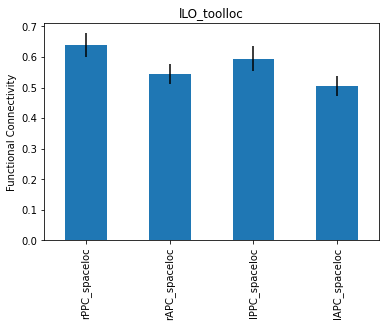

rLO_toolloc


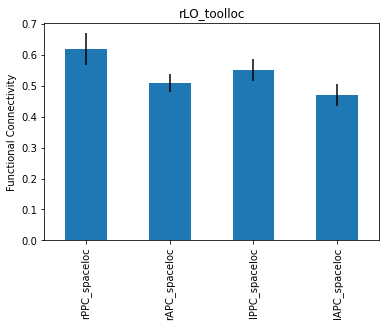

In [17]:
"""
extract avg signal in LO  and PFS

"""
ventral_rois = ['LO_toolloc']
rois = ["rPPC_spaceloc", "rAPC_spaceloc", "lPPC_spaceloc", "lAPC_spaceloc"]

#For each ventral ROI
for lr in ['l', 'r']:
    for vr in ventral_rois:    
        summary_df = pd.DataFrame(columns = ['sub'] + [rr for rr in rois])
        #summary_df = pd.DataFrame(columns = ['sub'] + ['r' + rr for rr in rois])
        ventral = f'{lr}{vr}'
        
        print(ventral)
        for ss in subj_list:
            
            sub_dir = f'{study_dir}/sub-{study}{ss}/ses-02/'
            roi_dir = f'{sub_dir}/derivatives/rois'
            
        
            ventral_mask = image.load_img(f'{roi_dir}/spheres/{ventral}_sphere.nii.gz')
            ventral_mask = input_data.NiftiMasker(ventral_mask)
                        
            roi_mean = []
            roi_mean.append(ss)
            #For each dorsal ROI
        
            for rr in rois:
                
                roi = rr
                if os.path.exists(f'{out_dir}/{study}{ss}_{rr}_mvpd_fishz.nii.gz'):
                    fc_img = image.load_img(f'{out_dir}/{study}{ss}_{rr}_mvpd_fishz.nii.gz')
                    
                    #ppi_img  = image.smooth_img(ppi_img, 6)
                    acts = ventral_mask.fit_transform(fc_img)

                    roi_mean.append(acts.mean())
                else:
                    roi_mean.append(np.nan)

            summary_df = summary_df.append(pd.Series(roi_mean, index = summary_df.columns), ignore_index = True)

        summary_df.to_csv(f'{results_dir}/mvpd/{ventral}_mvpd{file_suf}.csv', index=False)
        summary_df.iloc[:, 1:].mean().plot(kind = 'bar', title = ventral, ylabel = 'Functional Connectivity',
        yerr=[summary_df.iloc[:,1:].sem().to_list(), summary_df.iloc[:,1:].sem().to_list()])
        plt.pause(0.0001)

In [16]:
summary_df

,sub,rPPC_spaceloc,rAPC_spaceloc,lPPC_spaceloc,lAPC_spaceloc,lAPC_distloc
0,2001.0,0.460961,0.507273,0.458287,0.458287,0.494339
1,2002.0,0.829478,0.458770,0.453639,0.411626,0.565618
2,2003.0,0.653404,0.606474,NaN,NaN,0.706484
3,2004.0,0.676108,0.603783,0.520804,0.407809,0.439468
4,2005.0,0.821418,0.522141,0.647663,0.616236,0.520947
5,2007.0,0.462676,0.357948,0.615928,0.507388,0.324589
6,2008.0,0.585567,0.461075,0.426751,0.167999,0.170880
7,2012.0,0.290511,0.281292,NaN,NaN,0.273827
8,2013.0,0.415970,0.641063,0.528334,0.593979,0.602034
9,2014.0,0.775886,0.698252,0.701847,0.481417,0.668796


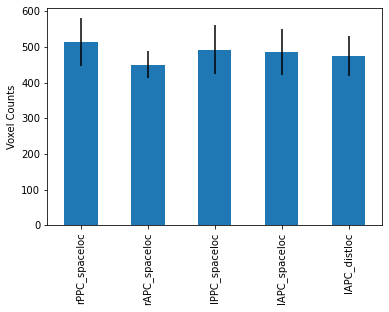

In [119]:
"""
Do non-parametric test in ventral mask
"""

ventral_mask = image.get_data(image.load_img('/user_data/vayzenbe/GitHub_Repos/fmri/roiParcels/mruczek_parcels/binary/ventral_visual_cortex.nii.gz'))
summary_df = pd.DataFrame(columns = ['sub'] + [rr for rr in rois])
for ss in subj_list:
        
    sub_dir = f'{study_dir}/sub-{study}{ss}/ses-02/'
    roi_dir = f'{sub_dir}/derivatives/rois'
                
    roi_mean = []
    roi_mean.append(ss)
    #For each dorsal ROI
    roi_counts = []
    roi_counts.append(ss)
    for rr in rois:
        if os.path.exists(f'{out_dir}/{study}{ss}_{rr}_mvpd_fishz.nii.gz'):
            curr_img = image.get_data(image.load_img(f'{out_dir}/{study}{ss}_{rr}_mvpd_z.nii.gz'))
            curr_count = np.count_nonzero(curr_img1[(ventral_mask >0) & (curr_img >2.5)])
            roi_counts.append(curr_count)
        else:
            roi_counts.append(np.nan)

    summary_df = summary_df.append(pd.Series(roi_counts, index = summary_df.columns), ignore_index = True)

    summary_df.to_csv(f'{results_dir}/{ventral}_mvpd.csv', index=False)
summary_df.iloc[:, 1:].mean().plot(kind = 'bar',ylabel = 'Voxel Counts',
yerr=[summary_df.iloc[:,1:].sem().to_list(), summary_df.iloc[:,1:].sem().to_list()])
plt.pause(0.0001)

        

In [121]:
summary_df

,sub,rPPC_spaceloc,rAPC_spaceloc,lPPC_spaceloc,lAPC_spaceloc,lAPC_distloc
0,2001,347,411,450,450,512
1,2002,1042,548,474,581,326
2,2003,283,360,NaN,NaN,458
3,2004,811,456,468,426,337
4,2005,278,212,259,194,304
5,2007,565,567,1051,443,647
6,2008,387,506,562,940,998
7,2012,406,506,NaN,NaN,473
8,2013,416,349,315,295,363
9,2014,448,284,405,359,486


In [120]:
roi_counts





rois = ["rPPC_spaceloc", "rAPC_spaceloc", "lPPC_spaceloc", "lAPC_spaceloc", "lAPC_distloc"]

all_count = []
for rr1 in rois:
    curr_img1 = image.get_data(image.load_img(f'{results_dir}/mvpd/{rr1}_mvpd.nii.gz'))
    curr_count1 = np.count_nonzero(curr_img1[(ventral_mask >0) & (curr_img1 >0)])
    for rr2 in rois:
        curr_img2 = image.get_data(image.load_img(f'{results_dir}/mvpd/{rr2}_mvpd.nii.gz'))
        curr_count2 = np.count_nonzero(curr_img2[(ventral_mask >0) & (curr_img2 >0)])

        prop = curr_count1/(curr_count1 +curr_count2)
        binom_p = binom_test(curr_count1, n=(curr_count1+curr_count2), p=0.5)
        print(rr1,rr2, prop, curr_count1, curr_count2, np.round_(binom_p,))




rPPC_spaceloc rPPC_spaceloc 0.5 12415 12415 1.0
rPPC_spaceloc rAPC_spaceloc 0.5626812907904278 12415 9649 0.0
rPPC_spaceloc lPPC_spaceloc 0.5825083282503636 12415 8898 0.0
rPPC_spaceloc lAPC_spaceloc 0.6303630363036303 12415 7280 0.0
rPPC_spaceloc lAPC_distloc 0.5989193882965893 12415 8314 0.0
rAPC_spaceloc rPPC_spaceloc 0.43731870920957217 9649 12415 0.0
rAPC_spaceloc rAPC_spaceloc 0.5 9649 9649 1.0
rAPC_spaceloc lPPC_spaceloc 0.5202458618644524 9649 8898 0.0
rAPC_spaceloc lAPC_spaceloc 0.5699686927757103 9649 7280 0.0
rAPC_spaceloc lAPC_distloc 0.5371597171964594 9649 8314 0.0
lPPC_spaceloc rPPC_spaceloc 0.41749167174963636 8898 12415 0.0
lPPC_spaceloc rAPC_spaceloc 0.4797541381355475 8898 9649 0.0
lPPC_spaceloc lPPC_spaceloc 0.5 8898 8898 1.0
lPPC_spaceloc lAPC_spaceloc 0.5500061812337743 8898 7280 0.0
lPPC_spaceloc lAPC_distloc 0.5169649082035789 8898 8314 0.0
lAPC_spaceloc rPPC_spaceloc 0.3696369636963696 7280 12415 0.0
lAPC_spaceloc rAPC_spaceloc 0.43003130722428967 7280 9649 0.0

In [81]:
binom_test(8800, n=(17212), p=0.5)

0.003178474576954759

In [86]:
from scipy.stats import chisquare
chisquare([8 , 18])

Power_divergenceResult(statistic=3.8461538461538463, pvalue=0.049860203756906855)

NameError: name 'chisquare' is not defined

In [64]:
(12415+8898)

21313

lLO_toolloc


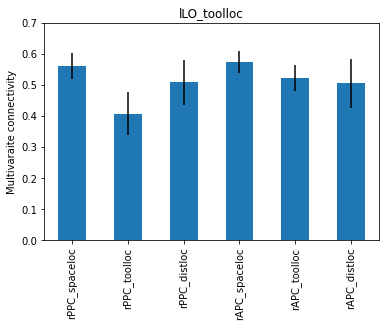

lPFS_toolloc


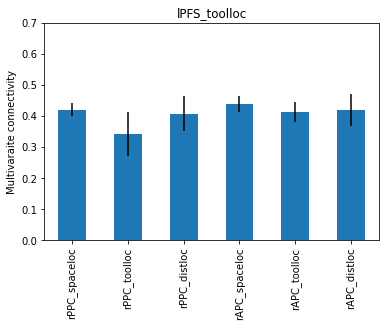

rLO_toolloc


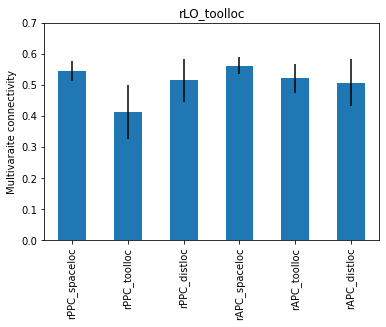

rPFS_toolloc


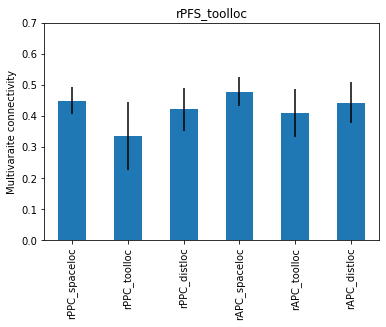

In [74]:
"""
analyze in ventral regions
"""

for lr in ['l','r']:
    for vr in ventral_rois:
        vroi = f'{lr}{vr}'
        roi_summary = pd.DataFrame(columns = ['sub'] + ['r' + dr for dr in dorsal_rois])
        for ss in subj_list:
            curr_df = pd.read_csv(f'{out_dir}/{study}{ss}_mvc.csv')
            curr_df = curr_df[curr_df['ventral_roi'] == vroi]
            
            roi_data = [ss]
            for lr2 in ['r']:
                for dr in dorsal_rois:
                    droi = f'{lr2}{dr}'
                    try:
                        roi_data.append(curr_df['mvc'][curr_df['dorsal_roi'] == droi].to_numpy()[0])
                    except:
                        roi_data.append(np.nan)

            
            roi_summary = roi_summary.append(pd.Series(roi_data, index = roi_summary.columns), ignore_index=True)
    
        print(vroi)
        roi_summary.to_csv(f'{results_dir}/{vroi}_mvc_summary.csv', index = False)
        roi_summary.iloc[:,1:].mean().plot(kind = 'bar', title = vroi, ylim = [0, .7], ylabel = 'Multivaraite connectivity',
        yerr=[roi_summary.iloc[:,1:].sem().to_list(), roi_summary.iloc[:,1:].sem().to_list()])
        plt.pause(0.0001)


    

